Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.2081 - mae: 0.2987 - val_loss: 0.0147 - val_mae: 0.0916
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0405 - mae: 0.1333 - val_loss: 0.0197 - val_mae: 0.1073
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0312 - mae: 0.1174 - val_loss: 0.0169 - val_mae: 0.1032
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0308 - mae: 0.1126 - val_loss: 0.0158 - val_mae: 0.0974
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0285 - mae: 0.1089 - val_loss: 0.0134 - val_mae: 0.0830
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0198 - mae: 0.0944 - val_loss: 0.0102 - val_mae: 0.0694
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0230 - mae: 0.1001 - val_loss: 0.0107 - val_mae: 0.0666
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0189 - mae: 0.0872 - val_loss: 0.0079 - val_mae: 0.0439
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - lo

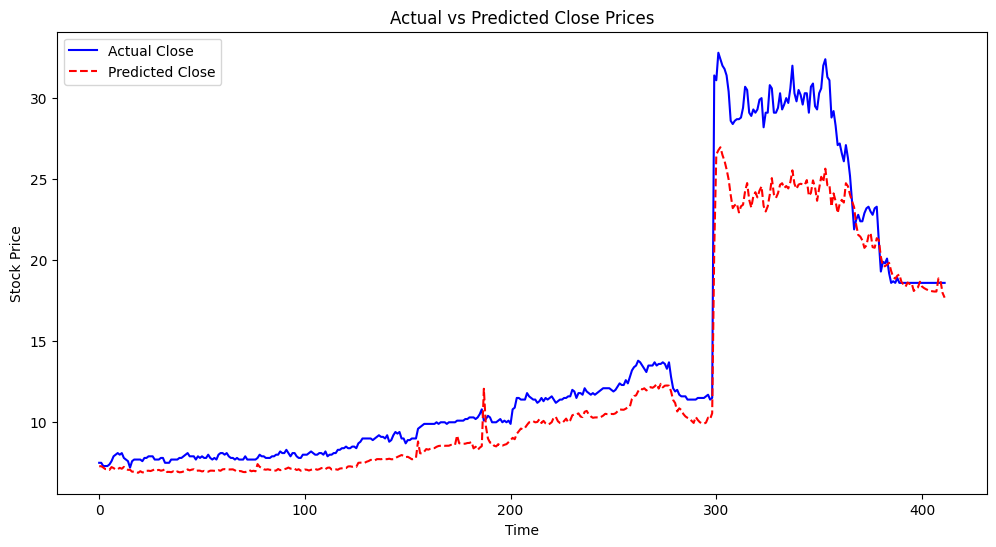

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, LSTM, Conv1D, Add, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score


df = pd.read_csv("/content/drive/MyDrive/Time series/stock_data.csv")


if 'VALUE' in df.columns:
    df = df.drop(columns=['VALUE'])


df['DATE'] = pd.to_datetime(df['DATE'])


le = LabelEncoder()
df['Scrip_encoded'] = le.fit_transform(df['TRADINGCODE'])


features = ['OPENP*', 'HIGH', 'LOW', 'CLOSEP*', 'VOLUME']


for col in features:
    df[col] = df[col].replace({',': ''}, regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')


df['VOLUME'] = df['VOLUME'].fillna(df['VOLUME'].median())


scaler = RobustScaler()
df_scaled = scaler.fit_transform(df[features])
df_scaled = pd.DataFrame(df_scaled, columns=features)

# Attach encoded Scrip
df_scaled['Scrip_encoded'] = df['Scrip_encoded'].values


def create_sequences_with_scrip(data, scrips, seq_length=60):
    X, y, scrip_ids = [], [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, 3])
        scrip_ids.append(scrips[i+seq_length])
    return np.array(X), np.array(y), np.array(scrip_ids)

# Create sequences
seq_length = 30
X, y, scrip_input = create_sequences_with_scrip(df_scaled.values, df_scaled['Scrip_encoded'].values, seq_length)

# Train-test split
split = int(0.85 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
scrip_train, scrip_test = scrip_input[:split], scrip_input[split:]

# === 10. Build model (unchanged) ===
def build_model(input_shape, num_scrips, embedding_dim=8):
    stock_input = Input(shape=input_shape, name="stock_input")
    scrip_input_layer = Input(shape=(1,), name="scrip_input")

    # Scrip embedding
    scrip_embedding = Embedding(input_dim=num_scrips, output_dim=embedding_dim)(scrip_input_layer)
    scrip_embedding = Flatten()(scrip_embedding)
    scrip_embedding = Dense(32, activation="relu")(scrip_embedding)

    # Residual CNN block
    x = Conv1D(64, kernel_size=3, padding="same", activation="relu")(stock_input)
    x = Conv1D(64, kernel_size=3, padding="same", activation="relu")(x)
    shortcut = Conv1D(64, kernel_size=1, padding="same")(stock_input)
    x = Add()([x, shortcut])
    x = BatchNormalization()(x)

    # LSTM
    x = LSTM(64, return_sequences=False)(x)

    # Combine features
    combined = Concatenate()([x, scrip_embedding])
    combined = Dense(128, activation="relu")(combined)
    combined = Dropout(0.3)(combined)
    output = Dense(1, activation="linear")(combined)

    model = Model(inputs=[stock_input, scrip_input_layer], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(0.0005), loss="mse", metrics=["mae"])
    return model

# Build and train
num_scrips = len(le.classes_)
model = build_model(X_train.shape[1:], num_scrips)
history = model.fit(
    {"stock_input": X_train, "scrip_input": scrip_train},
    y_train,
    epochs=100,
    batch_size=64,
    validation_data=({"stock_input": X_test, "scrip_input": scrip_test}, y_test),
    verbose=1
)

y_pred = model.predict({"stock_input": X_test, "scrip_input": scrip_test})


y_test_actual = scaler.inverse_transform(np.c_[np.zeros((len(y_test), 3)), y_test, np.zeros(len(y_test))])[:, 3]
y_pred_actual = scaler.inverse_transform(np.c_[np.zeros((len(y_pred), 3)), y_pred, np.zeros(len(y_pred))])[:, 3]


r2 = r2_score(y_test_actual, y_pred_actual)
print(f"R² Score: {r2:.4f}")

def directional_accuracy(actual, predicted):
    actual_direction = np.sign(np.diff(actual))
    predicted_direction = np.sign(np.diff(predicted))
    return np.mean(actual_direction == predicted_direction) * 100

da = directional_accuracy(y_test_actual, y_pred_actual)
print(f"Directional Accuracy: {da:.2f}%")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Close", color="blue")
plt.plot(y_pred_actual, label="Predicted Close", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Close Prices")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error


mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual) * 100
# Calculate Regression Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


direction_actual = np.sign(np.diff(y_test))
direction_pred = np.sign(np.diff(y_pred.reshape(-1)))
direction_accuracy = np.mean(direction_actual == direction_pred) * 100

# Print Results
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Directional Accuracy: {direction_accuracy:.2f}%")

MAE: 0.09
MSE: 0.01
RMSE: 0.12
R² Score: 0.8994
Directional Accuracy: 40.88%


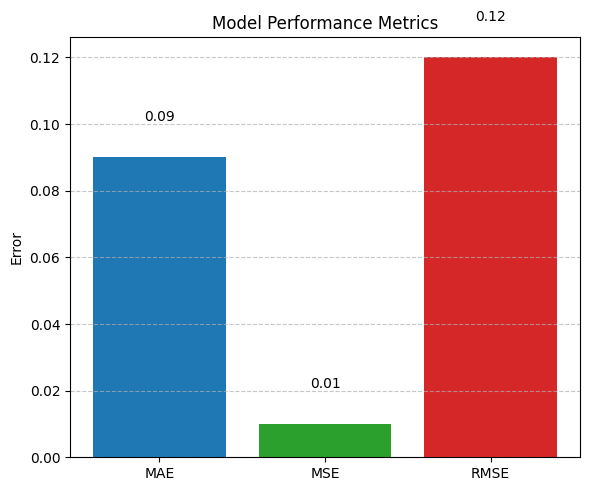

In [ ]:
import matplotlib.pyplot as plt

metrics = ['MAE', 'MSE', 'RMSE']
values = [0.09, 0.01, 0.12]
colors = ['#1f77b4', '#2ca02c', '#d62728']  # Blue, Green, Red

plt.figure(figsize=(6, 5))
bars = plt.bar(metrics, values, color=colors)
plt.title("Model Performance Metrics")
plt.ylabel("Error")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()


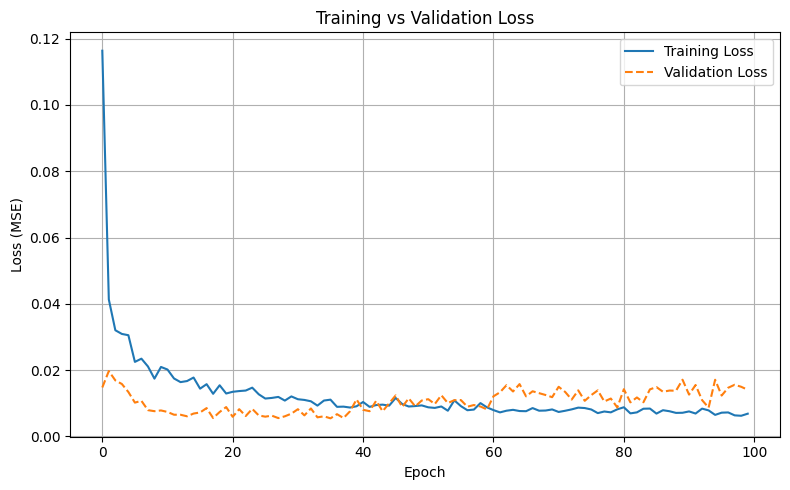

In [ ]:
# Plot training/validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
